# Gradient Boosing (XGBoost) Model

### Start by getting data

In [70]:
import yfinance as yf
import xgboost as xgb
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import time
from io import StringIO
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [71]:
# scrape the S&P 500 from wikipedia
wiki_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

response = requests.get(wiki_url)

wiki_tables = pd.read_html(StringIO(response.text))

sp500_table = wiki_tables[0]
ticker_list = sp500_table["Symbol"].tolist()
ticker_list = [ticker.replace(".","-") for ticker in ticker_list]
ticker_list = ticker_list[:50]

# look at a 5 year window
start_date = "2020-01-01"
end_date = "2025-01-01"


def get_stock_data(ticker, start_date=start_date, end_date=end_date):
    """ Gets the historic data for a stock based on the ticker and a date range.

    Args:
        ticker (str): The stock ticker
    Returns:
        stock (Pandas DataFrame): time-series historical data for a stock
    """

    temp_df = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
    temp_df.columns = temp_df.columns.droplevel(1)

    return temp_df

all_stock_data = []

for ticker in tqdm(ticker_list, desc="Downloading stocks..."):

    temp_df = get_stock_data(ticker)

    if temp_df.empty or temp_df.isna().all().all():
        print(f"Error getting {ticker}")
    else:
         all_stock_data.append(temp_df)

    time.sleep(1)


print(f"Collected {len(all_stock_data)} stocks")

Collected 50 stocks


In [72]:
# Compute the RSI and add it as a column.
def compute_rsi(series, window=14):
    """Computes the Relative Strength Index (RSI) for a given series."""
    diff_series = series.diff()
    # Gains and losses
    gains = diff_series.apply(lambda x: x if x > 0 else 0)
    losses = diff_series.apply(lambda x: -x if x < 0 else 0)
    # Average gain and loss over a sliding window
    avg_gain = gains.rolling(window=window, min_periods=window).mean()
    avg_loss = losses.rolling(window=window, min_periods=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


def classify_rsi(rsi):
    """Classifies an RSI value into Overbought, Oversold or Neutral."""
    if np.isnan(rsi):
        return np.nan
    if rsi > 70:
        return "Overbought"
    elif rsi < 30:
        return "Oversold"
    else:
        return "Neutral"


# Compute the RSI and RSI class for all stocks
for stock_data, ticker in zip(all_stock_data, ticker_list):
    stock_data['RSI'] = compute_rsi(stock_data['Close'])
    stock_data['RSI_class'] = stock_data['RSI'].apply(classify_rsi)

# Example for one stock (e.g., $MMM if it is first in the list)
print("Example data for " + ticker_list[0])
print(all_stock_data[0].head(20))

Example data for MMM
Price            Close        High         Low        Open    Volume  \
Date                                                                   
2020-01-02  122.357437  122.364235  120.413308  120.780382   4307633   
2020-01-03  121.303833  121.446581  119.386895  120.331774   2950412   
2020-01-06  121.419357  121.480540  119.876293  120.420106   2389608   
2020-01-07  120.929939  121.344601  120.195790  121.188244   2598908   
2020-01-08  122.785683  123.377083  120.759988  120.997910   3298927   
2020-01-09  123.173149  123.438251  122.194292  123.383879   3284575   
2020-01-10  122.676941  123.839335  122.452615  123.451866   2516145   
2020-01-13  122.982841  123.873335  122.602171  122.996438   2500597   
2020-01-14  123.288704  124.090822  122.500183  122.982813   3481795   
2020-01-15  122.207855  123.621767  121.800005  123.322674   2968711   
2020-01-16  123.044006  123.173158  122.146715  122.819680   2571280   
2020-01-17  123.275108  123.818922  122.833

In [73]:
# Implement logarithmic returns and volatility as new columns.
def compute_log_return(series):
    """Computes the logarithmic return of a series."""
    day_offset = series.shift(1)
    return np.log(series / day_offset)


def compute_volatility(series, window=14):
    """Computes the volatility of a logarithmic return series using a rolling window."""
    volatility = series.rolling(window=window, min_periods=window).std()
    return volatility


# Compute log returns and volatility for all stocks
for stock_data, ticker in zip(all_stock_data, ticker_list):
    stock_data['Log_return'] = compute_log_return(stock_data['Close'])
    stock_data['Volatility'] = compute_volatility(stock_data['Log_return'])

print("Example data for " + ticker_list[0])
print(all_stock_data[0].head(20))

Example data for MMM
Price            Close        High         Low        Open    Volume  \
Date                                                                   
2020-01-02  122.357437  122.364235  120.413308  120.780382   4307633   
2020-01-03  121.303833  121.446581  119.386895  120.331774   2950412   
2020-01-06  121.419357  121.480540  119.876293  120.420106   2389608   
2020-01-07  120.929939  121.344601  120.195790  121.188244   2598908   
2020-01-08  122.785683  123.377083  120.759988  120.997910   3298927   
2020-01-09  123.173149  123.438251  122.194292  123.383879   3284575   
2020-01-10  122.676941  123.839335  122.452615  123.451866   2516145   
2020-01-13  122.982841  123.873335  122.602171  122.996438   2500597   
2020-01-14  123.288704  124.090822  122.500183  122.982813   3481795   
2020-01-15  122.207855  123.621767  121.800005  123.322674   2968711   
2020-01-16  123.044006  123.173158  122.146715  122.819680   2571280   
2020-01-17  123.275108  123.818922  122.833

In [74]:
# days to earnings report stuff
API_KEY = "KN09FOBQUUDZTA9R"
ticker = "AAPL"

url = f"https://www.alphavantage.co/query?function=EARNINGS&symbol={ticker}&apikey={API_KEY}"
response = requests.get(url)
data = response.json()

# Example: Print the first few quarterly earnings reports
earnings_history = data.get("quarterlyEarnings", [])
print([report for report in earnings_history[:5]])

[]


In [75]:
# example of alpha
API_KEY = "GDEK4PY7POOU14P5"
ticker = "AAPL"

url = f"https://www.alphavantage.co/query?function=EARNINGS&symbol={ticker}&apikey={API_KEY}"
response = requests.get(url)
data = response.json()


def get_earnings_data(ticker):

    # get the data, return nothing if empty
    url = f"https://www.alphavantage.co/query?function=EARNINGS&symbol={ticker}&apikey={API_KEY}"
    response = requests.get(url)
    data = response.json()

    if "quarterlyEarnings" not in data:
        return None

    # convert the date to a datetime and the EPS to a float
    earnings_df = pd.DataFrame(data['quarterlyEarnings'])
    earnings_df['reportedDate'] = pd.to_datetime(earnings_df['reportedDate'])
    earnings_df['reportedEPS'] = pd.to_numeric(earnings_df['reportedEPS'])

    return earnings_df


def add_earnings_info(stock_df, earnings_df):

    # check if earnings df is empty
    if earnings_df is None:
        print("Error: Earnings data is None. Please check the data retrieval process.")
        return None

    # create columns, fill with NaN
    stock_df['Days_to_Earnings'] = np.nan
    stock_df['Last_EPS'] = np.nan

    # ensure earnings_df is sorted, then get it as a list
    earnings_dates = earnings_df['reportedDate'].sort_values().tolist()

    # iterate through rows -- current_date is the index
    for current_date, row in stock_df.iterrows():

        # create sublists of dates that are ahead and behind the current date
        future_earnings = [date for date in earnings_dates if date >= current_date]
        past_earnings = [date for date in earnings_dates if date < current_date]

        # check if there are future earnings
        if future_earnings:
            next_earnings_date = future_earnings[0]
            days_to_earnings = (next_earnings_date - current_date).days
            stock_df.at[current_date, 'Days_to_Earnings'] = days_to_earnings

        # check if there are past earnings
        if past_earnings:
            last_earnings_row = earnings_df.loc[earnings_df['reportedDate'] == past_earnings[-1]]
            last_eps = last_earnings_row['reportedEPS'].values[0]
            stock_df.at[current_date, 'Last_EPS'] = last_eps


# run this for every company, using tqdm to track progress
for stock_data, ticker in tqdm(zip(all_stock_data, ticker_list), total=len(all_stock_data)):
    add_earnings_info(stock_data, get_earnings_data(ticker))
    time.sleep(1)

100%|██████████| 50/50 [01:30<00:00,  1.81s/it]


In [76]:
# example -- printing stock data for MMM, we can see that when Days_to_earnings resets, Last_EPS changes
add_earnings_info(all_stock_data[0],get_earnings_data(ticker_list[0]))
all_stock_data[0][10:25]

Price,Close,High,Low,Open,Volume,RSI,RSI_class,Log_return,Volatility,Days_to_Earnings,Last_EPS
Date,,,,,,,,,,,
2020-01-16,123.044006,123.173158,122.146715,122.819680,2571280,NaN,NaN,0.006819,NaN,12.0,2.58
2020-01-17,123.275108,123.818922,122.833267,123.037198,4413360,NaN,NaN,0.001876,NaN,11.0,2.58
2020-01-21,121.942780,123.655785,121.426159,123.614996,4027769,NaN,NaN,-0.010867,NaN,7.0,2.58
2020-01-22,121.018295,122.744897,120.916336,122.024357,2894559,42.887983,Neutral,-0.007610,NaN,6.0,2.58
2020-01-23,120.821182,121.297014,119.903496,120.365732,2820646,42.008458,Neutral,-0.001630,0.007111,5.0,2.58
2020-01-24,121.099869,122.228272,120.678422,121.330993,3161148,48.845943,Neutral,0.002304,0.006788,4.0,2.58
2020-01-27,119.386864,122.758490,119.325681,122.262263,5216234,40.260535,Neutral,-0.014246,0.007751,1.0,2.58
2020-01-28,112.555237,117.150440,112.194973,116.851347,10669157,25.040417,Oversold,-0.058925,0.017297,0.0,2.58
2020-01-29,110.121674,113.160215,109.802186,113.078638,6391304,13.513439,Oversold,-0.021858,0.016771,90.0,2.15


### Training model

start by preprocessing data

In [77]:
for stock_data in all_stock_data:
    stock_data.reset_index(inplace=True)

In [80]:
all_stock_data[0][10:25]

Price,Date,Close,High,Low,Open,Volume,RSI,RSI_class,Log_return,Volatility,Days_to_Earnings,Last_EPS
10,2020-01-16,123.044006,123.173158,122.146715,122.819680,2571280,NaN,NaN,0.006819,NaN,12.0,2.58
11,2020-01-17,123.275108,123.818922,122.833267,123.037198,4413360,NaN,NaN,0.001876,NaN,11.0,2.58
12,2020-01-21,121.942780,123.655785,121.426159,123.614996,4027769,NaN,NaN,-0.010867,NaN,7.0,2.58
13,2020-01-22,121.018295,122.744897,120.916336,122.024357,2894559,42.887983,Neutral,-0.007610,NaN,6.0,2.58
14,2020-01-23,120.821182,121.297014,119.903496,120.365732,2820646,42.008458,Neutral,-0.001630,0.007111,5.0,2.58
15,2020-01-24,121.099869,122.228272,120.678422,121.330993,3161148,48.845943,Neutral,0.002304,0.006788,4.0,2.58
16,2020-01-27,119.386864,122.758490,119.325681,122.262263,5216234,40.260535,Neutral,-0.014246,0.007751,1.0,2.58
17,2020-01-28,112.555237,117.150440,112.194973,116.851347,10669157,25.040417,Oversold,-0.058925,0.017297,0.0,2.58
18,2020-01-29,110.121674,113.160215,109.802186,113.078638,6391304,13.513439,Oversold,-0.021858,0.016771,90.0,2.15
19,2020-01-30,110.468391,110.556755,107.919277,109.441948,5211092,13.309887,Oversold,0.003144,0.016771,89.0,2.15


In [89]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Assuming all_stock_data is a list of DataFrames where date is the index
# Step 1: Combine all data frames into a single DataFrame with ticker identification
combined_data = pd.DataFrame()

for i, df in enumerate(all_stock_data):
    df_copy = df.copy()
    # Reset index to make date a column
    df_copy = df_copy.reset_index()
    df_copy['ticker'] = f'stock_{i}'  # Add identifier
    combined_data = pd.concat([combined_data, df_copy], ignore_index=True)

# Data preprocessing
# Ensure date is datetime format
combined_data['Date'] = pd.to_datetime(combined_data['Date'])
combined_data.sort_values(['ticker', 'Date'], inplace=True)

# Feature engineering
# Calculate rolling volatility (target variable) - 10-day window example
def calculate_rolling_volatility(group, window=10):
    group['rolling_volatility'] = group['Log_return'].rolling(window=window).std() * np.sqrt(252)  # Annualized
    return group

combined_data = combined_data.groupby('ticker').apply(calculate_rolling_volatility).reset_index(drop=True)

# Create additional features
combined_data['day_of_week'] = combined_data['Date'].dt.dayofweek
combined_data['month'] = combined_data['Date'].dt.month
combined_data['year'] = combined_data['Date'].dt.year

# One-hot encode categorical variables
combined_data = pd.get_dummies(combined_data, columns=['RSI_class'], drop_first=True)

# Remove missing values
combined_data.dropna(inplace=True)

print(combined_data.head())

    index       Date       Close        High         Low        Open  \
14     14 2020-01-23  120.821182  121.297014  119.903496  120.365732   
15     15 2020-01-24  121.099869  122.228272  120.678422  121.330993   
16     16 2020-01-27  119.386864  122.758490  119.325681  122.262263   
17     17 2020-01-28  112.555237  117.150440  112.194973  116.851347   
18     18 2020-01-29  110.121674  113.160215  109.802186  113.078638   

      Volume        RSI  Log_return  Volatility  Days_to_Earnings  Last_EPS  \
14   2820646  42.008458   -0.001630    0.007111               5.0      2.58   
15   3161148  48.845943    0.002304    0.006788               4.0      2.58   
16   5216234  40.260535   -0.014246    0.007751               1.0      2.58   
17  10669157  25.040417   -0.058925    0.017297               0.0      2.58   
18   6391304  13.513439   -0.021858    0.016771              90.0      2.15   

     ticker  rolling_volatility  day_of_week  month  year  \
14  stock_0            0.094478

In [92]:
# Feature selection
# Select features and target
features = ['RSI', 'Log_return', 'Volume', 'Days_to_Earnings', 'Last_EPS',
            'day_of_week', 'month', 'year',
            'RSI_class_Oversold', 'RSI_class_Overbought', 'Volatility']
target = 'rolling_volatility'

X = combined_data[features]
y = combined_data[target]

# Split data for training and testing
# Time-based split (more appropriate for time series data)
tscv = TimeSeriesSplit(n_splits=5)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train XGBoost model
# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_scaled, label=y)

# Define parameters
params = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree',
    'eta': 0.1,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'tree_method': 'hist',  # For faster training
    'eval_metric': 'rmse'
}

# Train model
model = xgb.train(params, dtrain, num_boost_round=100)

# Model evaluation with cross-validation
def xgb_cv_rmse(X, y, params, nfolds=5):
    dtrain = xgb.DMatrix(X, label=y)
    cv_results = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=100,
        nfold=nfolds,
        metrics='rmse',
        early_stopping_rounds=20,
        seed=42
    )
    return cv_results['test-rmse-mean'].min()

rmse = xgb_cv_rmse(X_scaled, y, params)
print(f"Cross-validation RMSE: {rmse:.6f}")

# Hyperparameter tuning
def tune_xgb_hyperparameters(X, y):
    # For time series data, use sequential split rather than random
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9]
    }

    model = xgb.XGBRegressor(objective='reg:squarederror', tree_method='hist')
    grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print("Best parameters:", grid_search.best_params_)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Test RMSE: {rmse:.6f}")
    print(f"Test MAE: {mae:.6f}")
    print(f"R² Score: {r2:.6f}")

    return best_model

# Step 13: Prediction on new data
def predict_volatility(new_data, model, scaler, features):
    # Preprocess new data in the same way
    new_data = new_data[features].copy()
    new_data_scaled = scaler.transform(new_data)
    dtest = xgb.DMatrix(new_data_scaled)
    predictions = model.predict(dtest)
    return predictions

# Example: predict on the most recent data points
# Get the most recent data for each stock
recent_data = combined_data.groupby('ticker').tail(5)
predictions = predict_volatility(recent_data, model, scaler, features)
print("Predicted rolling volatility for recent data:")
print(predictions)

Cross-validation RMSE: 0.058596
Predicted rolling volatility for recent data:
[0.19402109 0.16863842 0.17248754 0.16629489 0.15760732 0.17732155
 0.17028879 0.16652626 0.13457341 0.13566542 0.16728266 0.15975127
 0.16027492 0.16270457 0.17046967 0.33501512 0.32308662 0.32612044
 0.3305736  0.32478955 0.21080637 0.21534473 0.21372409 0.21263362
 0.21354708 0.47968575 0.48029247 0.44598565 0.3908724  0.35043412
 0.27219656 0.27153292 0.27257866 0.2332011  0.2393921  0.4210897
 0.3917283  0.39099023 0.3760869  0.3780729  0.16759825 0.16841179
 0.1668534  0.16012852 0.15986778 0.13765869 0.13731115 0.13439897
 0.13487774 0.13514066 0.21544307 0.21358652 0.21414232 0.20030043
 0.18240486 0.39998657 0.3876948  0.40554193 0.40034857 0.36345404
 0.12266365 0.12484062 0.12554884 0.15414976 0.14615141 0.38719195
 0.3847744  0.39036697 0.39320728 0.35799536 0.17373459 0.1702914
 0.16104834 0.133004   0.13431859 0.30680615 0.30278692 0.28478956
 0.28620872 0.2885132  0.1568364  0.14175013 0.142888

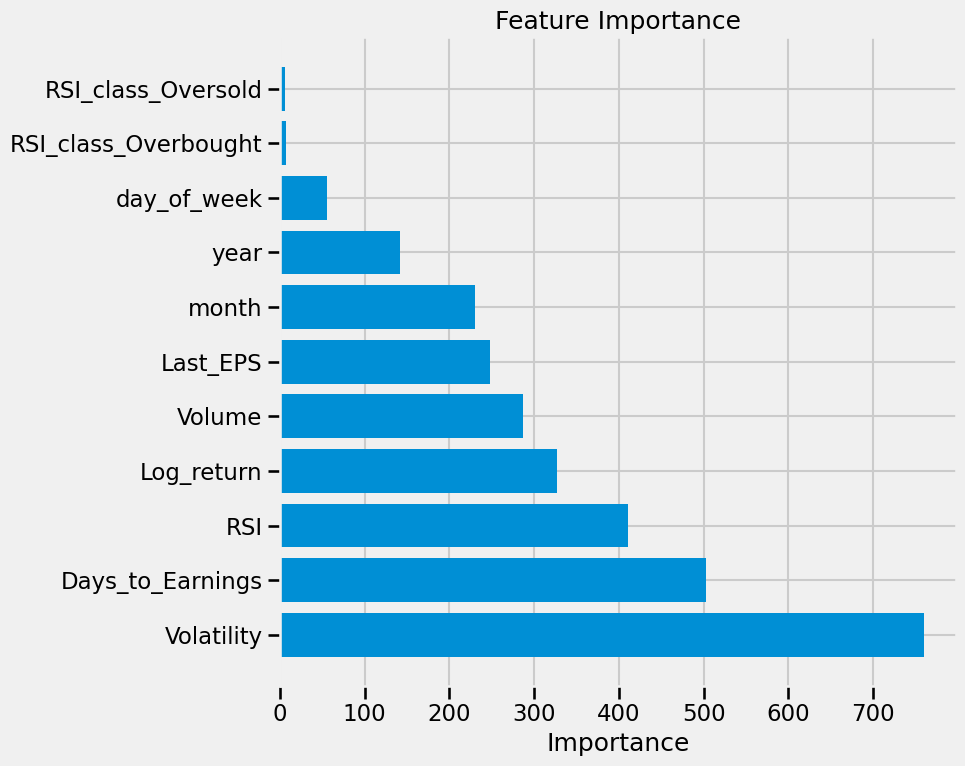

In [91]:
plt.figure(figsize=(10, 8))
importance = model.get_score(importance_type='weight')
importance = {k: v for k, v in sorted(importance.items(), key=lambda item: item[1], reverse=True)}

# Create a mapping of feature indices to feature names
feature_names = features  # Your feature list from before
feature_mapping = {f'f{i}': name for i, name in enumerate(feature_names)}

# Replace f0, f1, etc. with actual feature names
named_importance = {feature_mapping.get(k, k): v for k, v in importance.items()}

# Plot with actual feature names
plt.barh(list(named_importance.keys()), list(named_importance.values()))
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

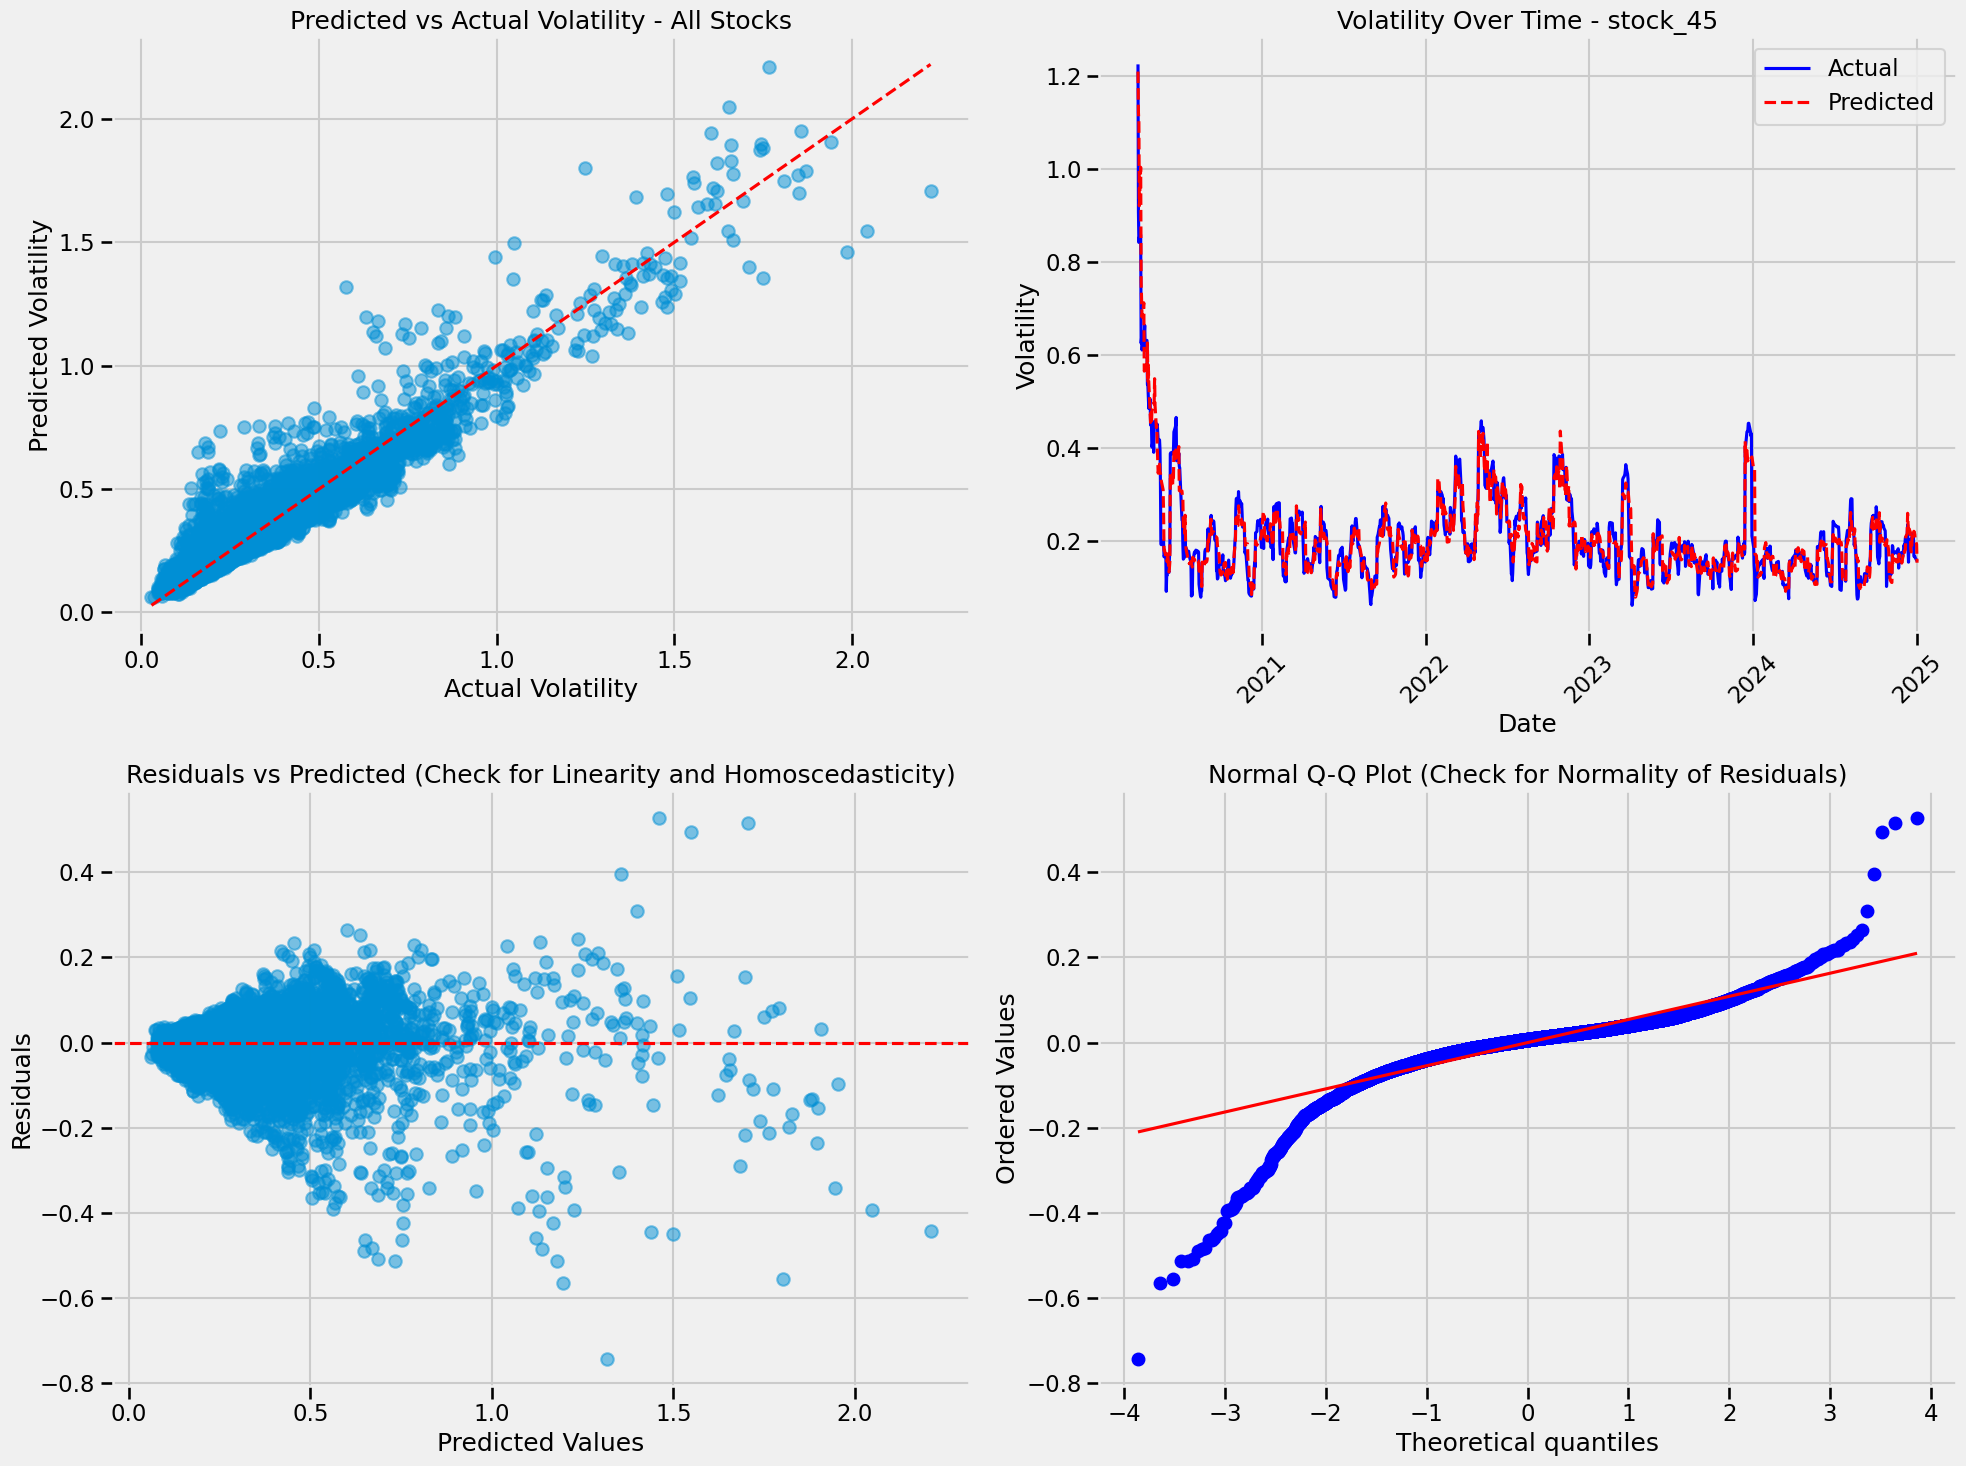

<Figure size 1000x600 with 0 Axes>

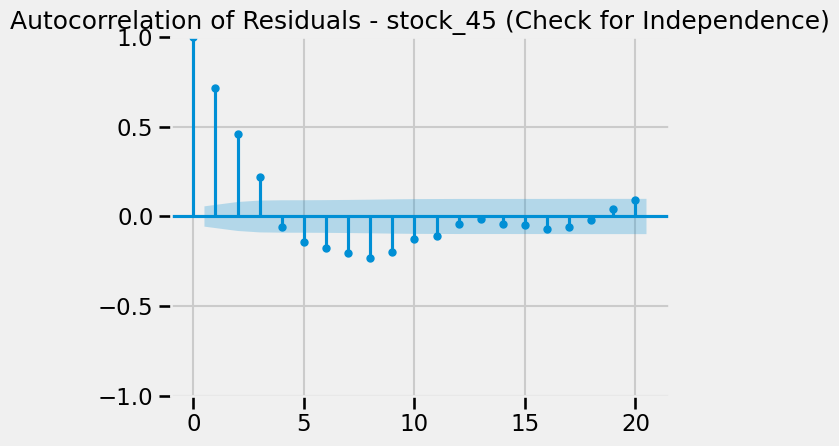

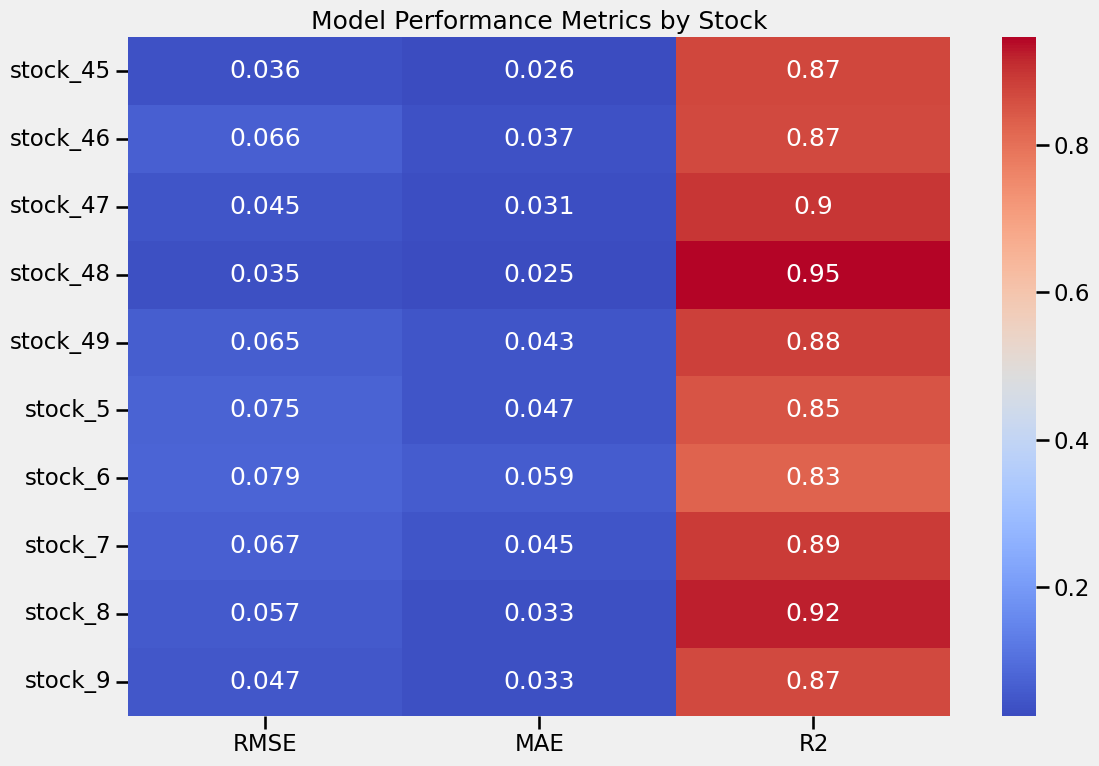

In [96]:
from scipy import stats

# Split data for training and testing (using time-based split)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Train the model (using the same parameters as before)
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
model = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions
dtest = xgb.DMatrix(X_test, feature_names=features)
y_pred = model.predict(dtest)

# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred,
    'Date': combined_data.loc[y_test.index, 'Date'].values,
    'Ticker': combined_data.loc[y_test.index, 'ticker'].values
})

# Calculate residuals
results_df['Residuals'] = results_df['Actual'] - results_df['Predicted']

# Create a multi-panel figure
plt.figure(figsize=(20, 15))

# 1. Predicted vs Actual Volatility - Overall
plt.subplot(2, 2, 1)
plt.scatter(results_df['Actual'], results_df['Predicted'], alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Volatility')
plt.ylabel('Predicted Volatility')
plt.title('Predicted vs Actual Volatility - All Stocks')

# 2. Predicted vs Actual for a specific stock
# Choose a specific stock to visualize
stock_tickers = results_df['Ticker'].unique()
if len(stock_tickers) > 0:
    selected_stock = stock_tickers[0]  # Choose the first stock, you can change this
    stock_df = results_df[results_df['Ticker'] == selected_stock].sort_values('Date')

    plt.subplot(2, 2, 2)
    plt.plot(stock_df['Date'], stock_df['Actual'], 'b-', label='Actual')
    plt.plot(stock_df['Date'], stock_df['Predicted'], 'r--', label='Predicted')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.title(f'Volatility Over Time - {selected_stock}')
    plt.legend()
    plt.xticks(rotation=45)

# 3. Check for Linearity and Homoscedasticity (Residuals plot)
plt.subplot(2, 2, 3)
plt.scatter(results_df['Predicted'], results_df['Residuals'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted (Check for Linearity and Homoscedasticity)')

# 4. Check for Normality of Residuals (QQ plot)
plt.subplot(2, 2, 4)
stats.probplot(results_df['Residuals'], dist="norm", plot=plt)
plt.title('Normal Q-Q Plot (Check for Normality of Residuals)')

plt.tight_layout()
plt.show()

# Additional plot: Autocorrelation of residuals to check independence
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10, 6))
# For a specific stock (time series autocorrelation makes more sense within one stock)
if len(stock_tickers) > 0:
    stock_residuals = results_df[results_df['Ticker'] == selected_stock]['Residuals'].values
    plot_acf(stock_residuals, lags=20, alpha=0.05)
    plt.title(f'Autocorrelation of Residuals - {selected_stock} (Check for Independence)')
plt.tight_layout()
plt.show()

# Create a heatmap of prediction accuracy across stocks
plt.figure(figsize=(12, 8))
stock_accuracy = results_df.groupby('Ticker').apply(
    lambda x: {'RMSE': np.sqrt(mean_squared_error(x['Actual'], x['Predicted'])),
               'MAE': mean_absolute_error(x['Actual'], x['Predicted']),
               'R2': r2_score(x['Actual'], x['Predicted'])})

# Convert to DataFrame for easier visualization
stock_metrics = pd.DataFrame.from_dict(dict(stock_accuracy), orient='index')
sns.heatmap(stock_metrics, annot=True, cmap='coolwarm')
plt.title('Model Performance Metrics by Stock')
plt.tight_layout()
plt.show()